In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import glob as gb
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Model
from joblib import  load

In [2]:
# Define Training dataset
# horizontal_flip = True
#   - Randomly flip images horizontally
# rescale = 1 / 255.0
#   - Rescale the image by 1 / 255.0
# flow_from_directory: 

train_dir = 'images/train'
Train_Data = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip = True,
    rescale = 1 / 255.0,
).flow_from_directory(
    train_dir, 
    batch_size = 16, 
    subset = "training", 
    target_size = (224, 224), # resize image to `224 x 224`
    shuffle = False 
)


Found 4000 images belonging to 4 classes.


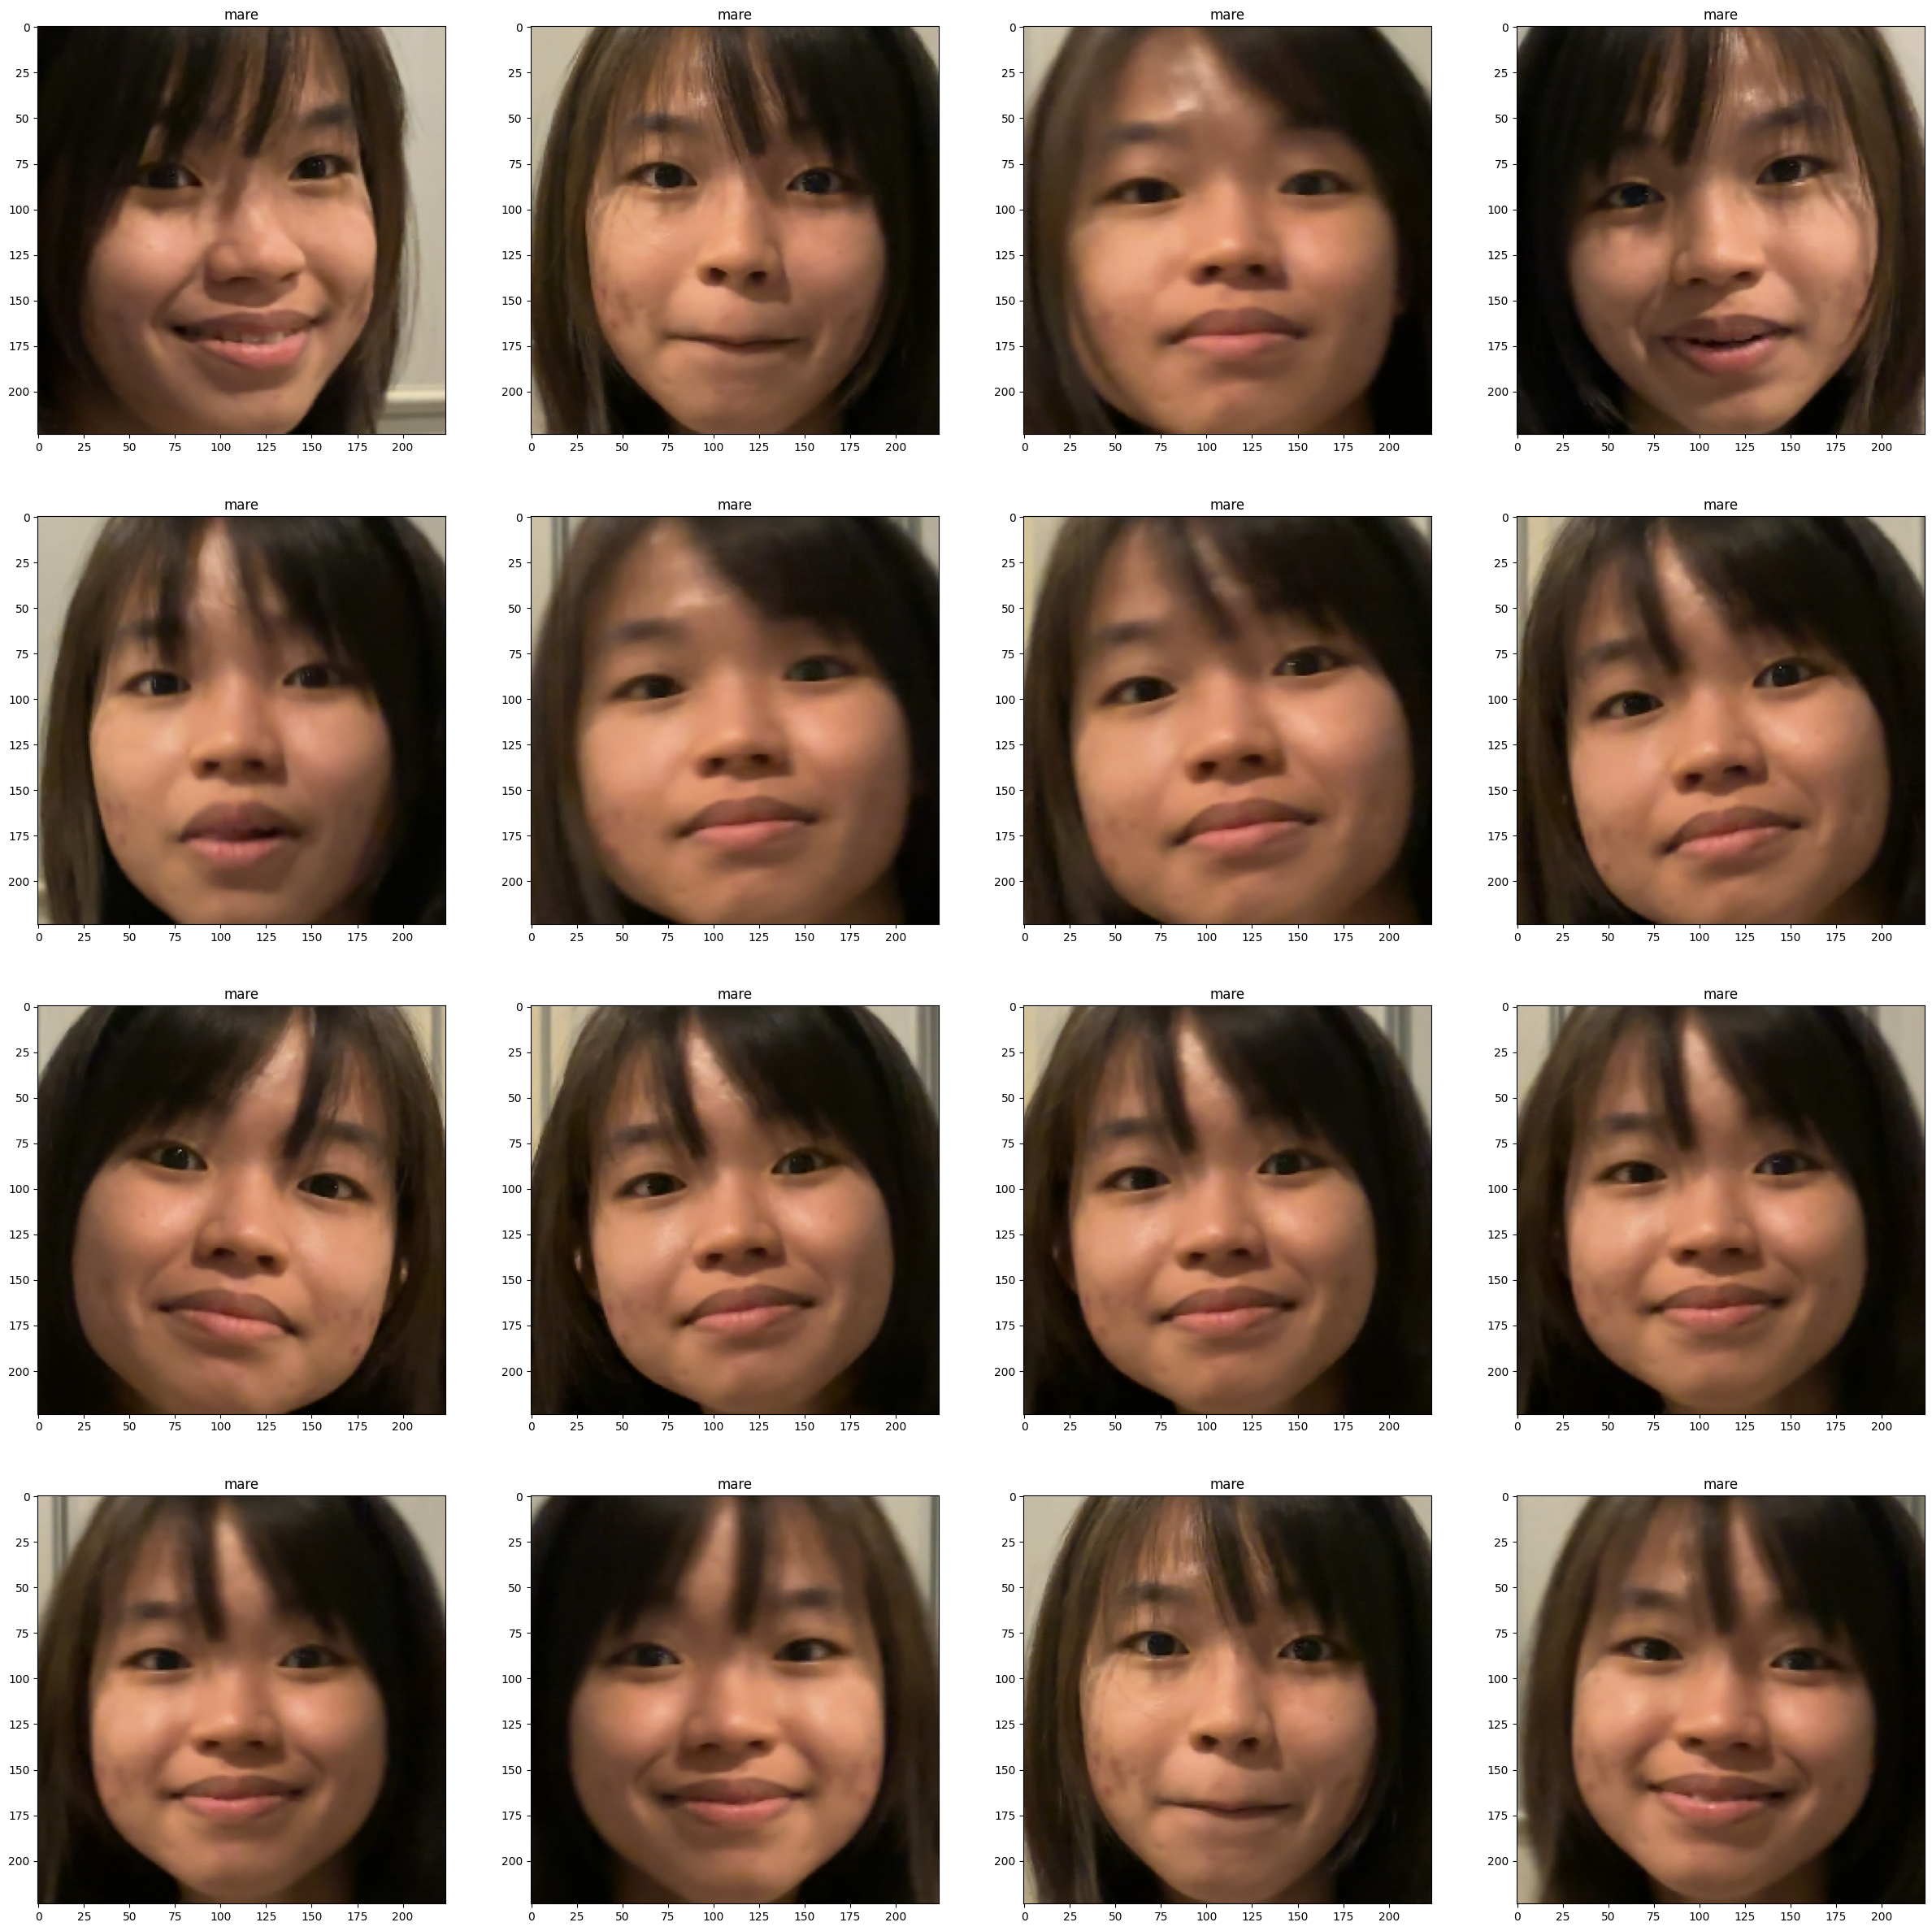

In [3]:
# Display the first 16 images from the training dataset
classes = list(Train_Data.class_indices.keys()) 
plt.figure(figsize=(30, 30))

# Iterate over batches of images and labels in the training dataset
for X_batch, y_batch in Train_Data: 
    # Iterate over the first 16 samples in the batch
    for i in range(0, 16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(X_batch[i])
        plt.title(classes[np.where(y_batch[i] == 1)[0][0]])
    plt.show()
    break


In [4]:
from models import vgg_face

model = vgg_face.vgg_face()

model.load_weights('models/vgg_face_weights.h5')

In [5]:
from tensorflow.keras.models import Model
model = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [6]:
scaler = load("dumped_model/scaler.joblib")
pca = load("dumped_model/pca_model.joblib")
clf = load("dumped_model/SVC.joblib")

In [22]:
from tensorflow.keras.utils import load_img
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import  img_to_array
import numpy as np
import cv2
from models import vgg_face

def create_VGGFace_descriptor():
    """Create and return the VGGFace model."""
    model = vgg_face.vgg_face()
    model.load_weights('./models/vgg_face_weights.h5') # Load the pre-trained weights
    # Extract the second-to-last layer as the output layer
    vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)
    return vgg_face_descriptor

def preprocess_image(image):
    if isinstance(image, str):  # Check if the input is a path
        img = load_img(image, target_size=(224, 224))  # Load the image from the path and resize it to the desired target size (224 x 224)
    else:
        img = image.copy()  # If the input is not a path, assume it's an image and make a copy 
        img = cv2.resize(img, (224, 224))  # Resize the image to the desired target size (224 x 224)
    
    img = img_to_array(img)  # Convert the image to a NumPy array : Convert the image to a NumPy array
    img = np.expand_dims(img, axis=0)  # Add a batch dimension : Expand the shape of an array
    img = preprocess_input(img)  # Preprocess the image : normalize the image and scale the pixel values to the range [-1, 1]
    return img

def findCosineDistance(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))
 
def verifyFace(roi, result, classes, vgg_face_descriptor, target_representation):
    epsilon = 0.35 # cosine similarity

    roi_representation = vgg_face_descriptor.predict(preprocess_image(roi))[0,:]
    
    mare_representation = target_representation['mare']
    plie_representation = target_representation['plie']
    tan_representation = target_representation['tan']
    
    mare_cosine_similarity = findCosineDistance(roi_representation, mare_representation)
    plie_cosine_similarity = findCosineDistance(roi_representation, plie_representation)
    tan_cosine_similarity = findCosineDistance(roi_representation, tan_representation)
    
    # Create a dictionary to associate each similarity score with its corresponding label
    similarities = {'mare': mare_cosine_similarity, 'plie': plie_cosine_similarity, 'tan': tan_cosine_similarity}
    
    min_similarity_label = min(similarities, key=similarities.get)
    min_similarity = similarities[min_similarity_label]
    confidence = 1 - min_similarity
    
    if (min_similarity > epsilon):
        min_similarity_label = 'unidentify'
        
    
    if len(result) == 1 :
        if min_similarity_label == classes[result[0]]:
            print("verified... they are same person") 
            return True,min_similarity_label, confidence
        else:
            print("unverified! they are not same person!")
            return False,min_similarity_label, confidence
    else:
        print("unverified! they are not same person!")
        return False,min_similarity_label, confidence

def Face_Recognition(roi, model, scaler, pca, clf):
    # Check if the input roi image is empty
    if roi is None or roi.shape[0] < 224 or roi.shape[1] < 224:
        return None, None
    
    # Region of Interest (ROI) : The face of the person to be recognized
    roi = cv2.resize(roi, dsize=(224, 224), interpolation=cv2.INTER_CUBIC) # Resize the image to 224 x 224
    roi = preprocess_image(roi) # Normalize the image and scale the pixel values to the range [-1, 1]
    embedding_vector = model.predict(roi)[0] # Extract the feature vector from the image

    embedding_vector = scaler.transform(embedding_vector.reshape(1, -1)) # Apply the scaler to the feature vector
    embedding_vector_pca = pca.transform(embedding_vector) # Apply PCA to the feature vector : Reduce the dimensionality of the feature vector
    y_predict = clf.predict_proba(embedding_vector_pca)[0] # Predict the probability of the class of the feature vector
    
    result = np.where(y_predict > 0.3)[0] # Set a threshold of 0.3 : if the probability of the class is greater than 0.3, then the class is recognized
    
    return result, y_predict # Return the recognized class and the probability of the class

def ImageClass(n):
    for x, y in classes.items(): # Iterate over the classes of the training data
        if n == y : # If the recognized class is equal to the class of the training data
            return x # Return the class of the training data
    

In [ ]:
from tensorflow.keras.utils import load_img
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import  img_to_array
import numpy as np
import cv2
from models import vgg_face

def create_VGGFace_descriptor():
    """Create and return the VGGFace model."""
    model = vgg_face.vgg_face()
    model.load_weights('./models/vgg_face_weights.h5') # Load the pre-trained weights
    # Extract the second-to-last layer as the output layer
    vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)
    return vgg_face_descriptor

def preprocess_image(image):
    if isinstance(image, str):  # Check if the input is a path
        img = load_img(image, target_size=(224, 224))  # Load the image from the path and resize it to the desired target size (224 x 224)
    else:
        img = image.copy()  # If the input is not a path, assume it's an image and make a copy 
        img = cv2.resize(img, (224, 224))  # Resize the image to the desired target size (224 x 224)
    
    img = img_to_array(img)  # Convert the image to a NumPy array : Convert the image to a NumPy array
    img = np.expand_dims(img, axis=0)  # Add a batch dimension : Expand the shape of an array
    img = preprocess_input(img)  # Preprocess the image : normalize the image and scale the pixel values to the range [-1, 1]
    return img

def findCosineDistance(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))
 
def verifyFace(roi, result, classes, vgg_face_descriptor, target_representation):
    epsilon = 0.35 # cosine similarity

    roi_representation = vgg_face_descriptor.predict(preprocess_image(roi))[0,:]
    
    mare_representation = target_representation['mare']
    plie_representation = target_representation['plie']
    tan_representation = target_representation['tan']
    
    mare_cosine_similarity = findCosineDistance(roi_representation, mare_representation)
    plie_cosine_similarity = findCosineDistance(roi_representation, plie_representation)
    tan_cosine_similarity = findCosineDistance(roi_representation, tan_representation)
    
    # Create a dictionary to associate each similarity score with its corresponding label
    similarities = {'mare': mare_cosine_similarity, 'plie': plie_cosine_similarity, 'tan': tan_cosine_similarity}
    
    min_similarity_label = min(similarities, key=similarities.get)
    min_similarity = similarities[min_similarity_label]
    confidence = 1 - min_similarity
    
    if (min_similarity > epsilon):
        min_similarity_label = 'unidentify'
        
    
    if len(result) == 1 :
        if min_similarity_label == classes[result[0]]:
            print("verified... they are same person") 
            return True,min_similarity_label, confidence
        else:
            print("unverified! they are not same person!")
            return False,min_similarity_label, confidence
    else:
        print("unverified! they are not same person!")
        return False,min_similarity_label, confidence

def Face_Recognition(roi, model, scaler, pca, clf):
    # Check if the input roi image is empty
    if roi is None or roi.shape[0] < 224 or roi.shape[1] < 224:
        return None, None
    
    # Region of Interest (ROI) : The face of the person to be recognized
    roi = cv2.resize(roi, dsize=(224, 224), interpolation=cv2.INTER_CUBIC) # Resize the image to 224 x 224
    roi = preprocess_image(roi) # Normalize the image and scale the pixel values to the range [-1, 1]
    embedding_vector = model.predict(roi)[0] # Extract the feature vector from the image

    embedding_vector = scaler.transform(embedding_vector.reshape(1, -1)) # Apply the scaler to the feature vector
    embedding_vector_pca = pca.transform(embedding_vector) # Apply PCA to the feature vector : Reduce the dimensionality of the feature vector
    y_predict = clf.predict_proba(embedding_vector_pca)[0] # Predict the probability of the class of the feature vector
    
    result = np.where(y_predict > 0.3)[0] # Set a threshold of 0.3 : if the probability of the class is greater than 0.3, then the class is recognized
    
    return result, y_predict # Return the recognized class and the probability of the class

def ImageClass(n):
    for x, y in classes.items(): # Iterate over the classes of the training data
        if n == y : # If the recognized class is equal to the class of the training data
            return x # Return the class of the training data
    

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN
import cv2
# from euclidean_distance import verifyFace
 
mtcnn = MTCNN(
    image_size=160, # The size of the image : 160 x 160
    margin=14, # Margin around the bounding box
    min_face_size=20, # Minimum face size
    device='cpu', 
    post_process=False
    )

cap = cv2.VideoCapture(0)
size = (1600, 1200) # Size of the frame
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, size[1]) # height of the frame
cap.set(cv2.CAP_PROP_FRAME_WIDTH, size[0]) # width of the frame
# classes = list(Train_Data.class_indices.keys())
classes_name = ['tan', 'mare', 'plie', 'unidentify']
        
result_video = cv2.VideoWriter(
                'videos/saved/buffer.mp4', # Name of the video file
                cv2.VideoWriter_fourcc(*'MJPG'), # Codec
                30, # Frames per second
                size, # Size of the frame
                )

font = cv2.FONT_HERSHEY_SIMPLEX # Font style
fontScale = 1 # Font scale
color = (255, 0, 0) # Font color
thickness = 2 # Font thickness
other = 0 # Counter for the class 'Other'

vgg_face_descriptor = create_VGGFace_descriptor()

# prediction of targeted people

mare_representation = vgg_face_descriptor.predict(preprocess_image('./images/euclidean/mare.png'))[0,:]
tan_representation = vgg_face_descriptor.predict(preprocess_image('./images/euclidean/tan.png'))[0,:]
plie_representation = vgg_face_descriptor.predict(preprocess_image('./images/euclidean/plie.png'))[0,:]

targeted_people_representation = {
    'mare': mare_representation, 
    'plie': plie_representation, 
    'tan': tan_representation
}
    
# Read until video is completed
while True : 
    ret, frame = cap.read() # Capture frame-by-frame
    if not ret: # If the frame is not read then break the loop
        break  
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB) # Convert the frame to RGB
    frame = cv2.resize(frame,(1600,1200),interpolation=cv2.INTER_CUBIC) # Resize the frame to 1600 x 1200
    frame = cv2.GaussianBlur(frame, ksize=(3,3), sigmaX=0) # Apply Gaussian blur to the frame
    frame_face = frame.copy() # Copy the frame for face detection
    frame_face = cv2.resize(frame_face,(640,640),interpolation=cv2.INTER_CUBIC) # Resize the frame to 640 x 640
    boxes, probs = mtcnn.detect(frame_face, landmarks=False) # Detect faces in the frame : boxes and probabilities

    if not probs.all() == None and probs.all() > 0.6 : # If the probability of the face is greater than 0.6
        for x1, y1, x2, y2 in boxes : # Iterate over the boxes of the detected faces
            # Convert the coordinates of the boxes to the original frame
            x1 = int(x1) * 1600 // 640 
            x2 = int(x2) * 1600 // 640
            y1 = int(y1) * 1200 // 640
            y2 = int(y2) * 1200 // 640
            
            roi = frame[y1:y2, x1:x2] # Region of interest : face
            result, y_predict = Face_Recognition(roi, model, scaler, pca, clf) # Recognize the face : result and probability of the class
            
            # if (result == None and y_predict == None) :
            #     print("No face detected")
            #     continue

            if result is None:
                continue
            
            if len(result) == 0: # If the length of the recognized class is equal to 0
                roi = cv2.cvtColor(roi,cv2.COLOR_RGB2BGR) # Convert the region of interest to BGR (Blue-Green-Red)
                cv2.imwrite(f'Pic{other}.png', roi) # Save the region of interest
                cv2.putText(frame, 'Other' , (x1-5,y1-5), font,fontScale, color, thickness, cv2.LINE_AA) # Write 'Other'
                other = other + 1 # Increment the counter
            else:
                verification_result, verification_person, verification_confidence = verifyFace(
                                                                                        roi, 
                                                                                        result, 
                                                                                        classes_name, 
                                                                                        vgg_face_descriptor, 
                                                                                        targeted_people_representation,
                                                                                    ) 
                
                if verification_result is None:
                    continue
                
                confidence = 0
                
                # If the face is verified
                if not verification_result:
                    color = (0, 255, 0) # Green
                    
                if verification_person == 'unidentify':
                    blur_roi = cv2.GaussianBlur(roi, (99, 99), 30) # Apply Gaussian blur to the region of interest
                    frame[y1:y2, x1:x2] = blur_roi # Replace the region of interest with the blurred region of interest
                
                if len(result) == 1:
                    if verification_person == ImageClass(result[0]):
                        confidence = y_predict[result[0]]
                    else:
                        confidence = verification_confidence
                else:
                    for i in range(len(result)):
                        if verification_person == ImageClass(result[i]):
                            confidence = y_predict[result[i]]
                            break
                    if confidence == 0:
                        confidence = verification_confidence
                        
                    
            cv2.putText(frame, verification_person, (x1-5,y1-5), font, fontScale, color, thickness, cv2.LINE_AA)
            cv2.putText(frame, str(np.round(confidence,2)) , (x2,y2-10), font,fontScale, color, thickness, cv2.LINE_AA) # Write the probability of the class
            
                
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2) # Draw a rectangle around the face
    
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR) # Convert the frame to BGR (Blue-Green-Red)
    result_video.write(frame) # Write the frame to the video file 
    cv2.imshow('frame',frame) # Display the frame
    
    if cv2.waitKey(25) & 0xFF == ord('q'): # If 'q' is pressed then break the loop
        break
            
cap.release() # Release the video capture object
result_video.release() # Release the video writer object
cv2.destroyAllWindows()  # Close all the frames

OpenCV: FFMPEG: tag 0x47504a4d/'MJPG' is not supported with codec id 7 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
2024-03-13 00:02:02.025 Python[6782:47817] AVF: AVAssetWriter status: Cannot create file


1/1 [==============================] - 0s 260ms/step
unverified! they are not same person!
1/1 [==============================] - 0s 253ms/step
unverified! they are not same person!
1/1 [==============================] - 0s 277ms/step
unverified! they are not same person!
1/1 [==============================] - 0s 276ms/step
unverified! they are not same person!
1/1 [==============================] - 0s 266ms/step
unverified! they are not same person!
1/1 [==============================] - 0s 270ms/step
unverified! they are not same person!
1/1 [==============================] - 0s 300ms/step
unverified! they are not same person!
1/1 [==============================] - 0s 275ms/step
unverified! they are not same person!
1/1 [==============================] - 0s 283ms/step
unverified! they are not same person!
1/1 [==============================] - 0s 264ms/step
unverified! they are not same person!
1/1 [==============================] - 0s 279ms/step
unverified! they are not same person!